# A tensorflow model for Dictionary Filter

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

2024-07-13 11:46:08.898662: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 11:46:08.923864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 11:46:09.294755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import sys
sys.path.append('../Library')

from Metrics.NMSE import NMSE
from Modules.GaussianDictionaryFilter import GaussianDictionaryFilter as DictionaryFilter

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

## Test on Movie Lens 25M dataset

In [4]:
# Read the dataset
dataset = pd.read_csv('../Data/MovieLens/Recommended/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,7242,58197,3.5
1,21105,149680,4.0
2,6762,15512,4.5
3,2538,128,3.0
4,522,112086,5.0


In [5]:
from sklearn.model_selection import train_test_split
from AdvancedModelSelection import user_based_train_test_split

# Split the dataset into train and test data
train_val_data, test_data = user_based_train_test_split(dataset, test_size=0.2, random_state=42)

# Split the train and validation data
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (18000798, 3)
Validation data shape: (2000089, 3)
Test data shape: (4999208, 3)


In [6]:
NUM_MOVIES = dataset['Movie Index'].max() + 1
NUM_USERS = dataset['User Index'].max() + 1
NUM_FACTORS = 16
BATCH_SIZE = 32
TRAIN_LAMBDA = 2.0
INIT_SCALE = dataset['Rating'].mean() / NUM_FACTORS
NUM_EPOCHS = 20

In [7]:
# Convert train data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert validation data to sparse tensor
val_sparse_tensor = tf.sparse.SparseTensor(
    indices=val_data[['Movie Index', 'User Index']].values,
    values=val_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
val_sparse_tensor = tf.sparse.reorder(val_sparse_tensor)

# Convert test data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[NUM_MOVIES, NUM_USERS]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-13 11:46:48.454304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 11:46:48.472231: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 11:46:48.472272: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 11:46:48.473671: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 11:46:48.473708: I external/local_xla/xla/stream_executor

In [8]:
# Create dataset
def create_train_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

def create_full_dataset(batch_size=BATCH_SIZE):
    def data_generator():
        train_slices = tf.sparse.split(sp_input=train_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        val_slices = tf.sparse.split(sp_input=val_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        test_slices = tf.sparse.split(sp_input=test_sparse_tensor, num_split=NUM_USERS // batch_size, axis=1)
        for i in range(NUM_USERS // batch_size):
            yield (tf.sparse.to_dense(train_slices[i]), tf.sparse.to_dense(val_slices[i]), tf.sparse.to_dense(test_slices[i]))

    dataset = tf.data.Dataset.from_generator(
        data_generator, 
        output_signature=(
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32),
            tf.TensorSpec(shape=[NUM_MOVIES, None], dtype=tf.float32)
        )
    )

    return dataset

## Experiments
### 1. Batch size vs train time vs NMSE

In [9]:
# Initialize variables
batch_sizes = [8, 32, 128, 512]
nmse_train_results = np.zeros((len(batch_sizes), 5))
nmse_val_results = np.zeros((len(batch_sizes), 5))
train_timer = np.zeros((len(batch_sizes)))

for i, batch_size in enumerate(batch_sizes):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
    nmse_train = NMSE()
    nmse_val = NMSE()

    # Create the dataset
    dataset = create_train_dataset(batch_size)
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // batch_size, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train NMSE:", nmse_train.result().numpy())
        print("Val NMSE:", nmse_val.result().numpy())
        nmse_train_results[i, epoch] = nmse_train.result().numpy()
        nmse_val_results[i, epoch] = nmse_val.result().numpy()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

Epoch 1: 100%|██████████| 20317/20317 [04:28<00:00, 75.79batch/s]


Train NMSE: 0.060329337
Val NMSE: 0.06262082


Epoch 2: 100%|██████████| 20317/20317 [04:21<00:00, 77.62batch/s]


Train NMSE: 0.060123205
Val NMSE: 0.062408105


Epoch 3: 100%|██████████| 20317/20317 [04:21<00:00, 77.58batch/s]


Train NMSE: 0.06000781
Val NMSE: 0.062288824


Epoch 4: 100%|██████████| 20317/20317 [04:21<00:00, 77.74batch/s]


Train NMSE: 0.059927713
Val NMSE: 0.062206306


Epoch 5: 100%|██████████| 20317/20317 [04:21<00:00, 77.67batch/s]


Train NMSE: 0.059867036
Val NMSE: 0.062143527


Epoch 1: 100%|██████████| 5079/5079 [02:47<00:00, 30.27batch/s]


Train NMSE: 0.06085416
Val NMSE: 0.06324184


Epoch 2: 100%|██████████| 5079/5079 [02:47<00:00, 30.36batch/s]


Train NMSE: 0.060631413
Val NMSE: 0.063015595


Epoch 3: 100%|██████████| 5079/5079 [02:47<00:00, 30.35batch/s]


Train NMSE: 0.060507517
Val NMSE: 0.062888995


Epoch 4: 100%|██████████| 5079/5079 [02:46<00:00, 30.43batch/s]


Train NMSE: 0.060422186
Val NMSE: 0.06280155


Epoch 5: 100%|██████████| 5079/5079 [02:46<00:00, 30.47batch/s]


Train NMSE: 0.06035735
Val NMSE: 0.062735185


Epoch 1: 100%|██████████| 1269/1269 [02:35<00:00,  8.15batch/s]


Train NMSE: 0.061263297
Val NMSE: 0.063613705


Epoch 2: 100%|██████████| 1269/1269 [02:35<00:00,  8.14batch/s]


Train NMSE: 0.061014876
Val NMSE: 0.06335949


Epoch 3: 100%|██████████| 1269/1269 [02:33<00:00,  8.26batch/s]


Train NMSE: 0.060878683
Val NMSE: 0.06321999


Epoch 4: 100%|██████████| 1269/1269 [02:34<00:00,  8.23batch/s]


Train NMSE: 0.060785644
Val NMSE: 0.06312441


Epoch 5: 100%|██████████| 1269/1269 [02:34<00:00,  8.24batch/s]


Train NMSE: 0.06071537
Val NMSE: 0.063052095


Epoch 1: 100%|██████████| 317/317 [02:25<00:00,  2.18batch/s]


Train NMSE: 0.061296154
Val NMSE: 0.06366155


Epoch 2: 100%|██████████| 317/317 [02:25<00:00,  2.18batch/s]


Train NMSE: 0.06098438
Val NMSE: 0.063336074


Epoch 3: 100%|██████████| 317/317 [02:25<00:00,  2.18batch/s]


Train NMSE: 0.060816295
Val NMSE: 0.06316062


Epoch 4: 100%|██████████| 317/317 [02:26<00:00,  2.16batch/s]


Train NMSE: 0.060702313
Val NMSE: 0.06304183


Epoch 5: 100%|██████████| 317/317 [02:24<00:00,  2.19batch/s]

Train NMSE: 0.060616672
Val NMSE: 0.06295271


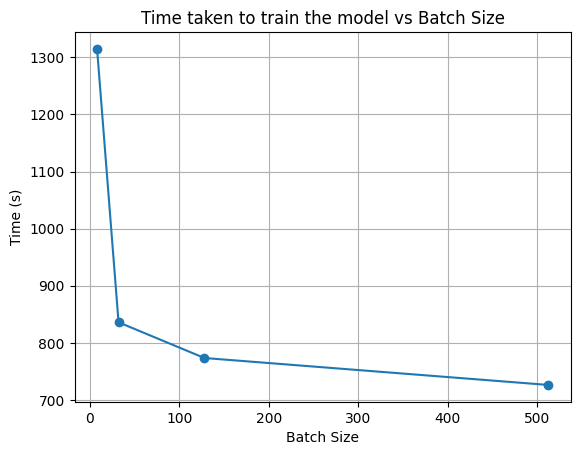

In [10]:
# Plot time taken to train the model vs batch size
plt.plot(batch_sizes, train_timer, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Batch Size')
plt.grid()
plt.show()

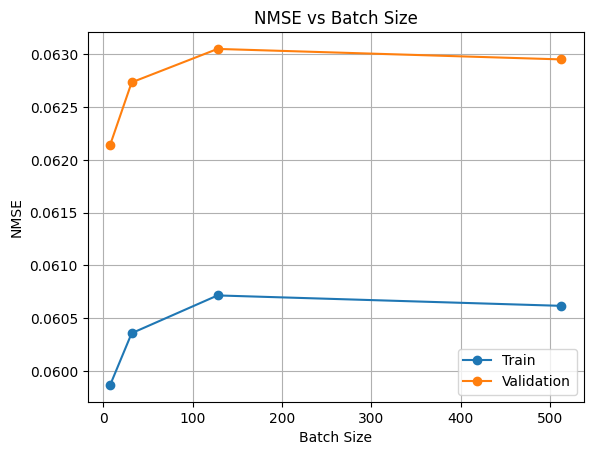

In [11]:
# Plot NMSE of the last epoch vs batch size
plt.plot(batch_sizes, nmse_train_results[:, -1], marker='o', label='Train')
plt.plot(batch_sizes, nmse_val_results[:, -1], marker='o', label='Validation')
plt.xlabel('Batch Size')
plt.ylabel('NMSE')
plt.title('NMSE vs Batch Size')
plt.legend()
plt.grid()
plt.show()

### 2. Number of factors vs NMSE

In [9]:
# Initialize variables
num_factors = [1, 2, 4, 8, 16, 32]
nmse_train_results = np.zeros((len(num_factors), 5))
nmse_val_results = np.zeros((len(num_factors), 5))
train_timer = np.zeros((len(num_factors)))

for i, num_factor in enumerate(num_factors):

    # Create the model
    model = DictionaryFilter(NUM_MOVIES, num_factor, INIT_SCALE, TRAIN_LAMBDA)
    nmse_train = NMSE()
    nmse_val = NMSE()

    # Create the dataset
    dataset = create_train_dataset()
        
    start_time = time.time()  # Start the timer

    # Train the model
    for epoch in range(5):
        progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
        
        for train_batch, val_batch in dataset:
            x = model(train_batch)
            nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
            nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
            progress_bar.update(1)
        
        progress_bar.close()

        print("Train NMSE:", nmse_train.result().numpy())
        print("Val NMSE:", nmse_val.result().numpy())
        nmse_train_results[i, epoch] = nmse_train.result().numpy()
        nmse_val_results[i, epoch] = nmse_val.result().numpy()

    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    train_timer[i] = elapsed_time  # Store the elapsed time

Epoch 1: 100%|██████████| 5079/5079 [02:35<00:00, 32.57batch/s]


Train NMSE: 0.061714962
Val NMSE: 0.062831774


Epoch 2: 100%|██████████| 5079/5079 [02:33<00:00, 33.00batch/s]


Train NMSE: 0.061500795
Val NMSE: 0.062613815


Epoch 3: 100%|██████████| 5079/5079 [02:31<00:00, 33.43batch/s]


Train NMSE: 0.061382655
Val NMSE: 0.062493436


Epoch 4: 100%|██████████| 5079/5079 [02:29<00:00, 33.91batch/s]


Train NMSE: 0.061301682
Val NMSE: 0.062410828


Epoch 5: 100%|██████████| 5079/5079 [02:30<00:00, 33.65batch/s]


Train NMSE: 0.06124035
Val NMSE: 0.06234851


Epoch 1: 100%|██████████| 5079/5079 [02:45<00:00, 30.75batch/s]


Train NMSE: 0.06085416
Val NMSE: 0.06324184


Epoch 2: 100%|██████████| 5079/5079 [02:44<00:00, 30.84batch/s]


Train NMSE: 0.060631413
Val NMSE: 0.063015595


Epoch 3: 100%|██████████| 5079/5079 [02:44<00:00, 30.85batch/s]


Train NMSE: 0.060507517
Val NMSE: 0.062888995


Epoch 4: 100%|██████████| 5079/5079 [02:44<00:00, 30.86batch/s]


Train NMSE: 0.060422186
Val NMSE: 0.06280155


Epoch 5: 100%|██████████| 5079/5079 [02:46<00:00, 30.55batch/s]


Train NMSE: 0.06035735
Val NMSE: 0.062735185


Epoch 1: 100%|██████████| 5079/5079 [03:35<00:00, 23.58batch/s]


Train NMSE: 0.05904952
Val NMSE: 0.063984975


Epoch 2: 100%|██████████| 5079/5079 [03:34<00:00, 23.63batch/s]


Train NMSE: 0.058812916
Val NMSE: 0.06373445


Epoch 3: 100%|██████████| 5079/5079 [03:39<00:00, 23.15batch/s]


Train NMSE: 0.05867989
Val NMSE: 0.063584894


Epoch 4: 100%|██████████| 5079/5079 [03:41<00:00, 22.95batch/s]


Train NMSE: 0.05858901
Val NMSE: 0.063487455


Epoch 5: 100%|██████████| 5079/5079 [03:36<00:00, 23.47batch/s]


Train NMSE: 0.05851942
Val NMSE: 0.063414685


Epoch 1: 100%|██████████| 5079/5079 [04:59<00:00, 16.97batch/s]


Train NMSE: 0.056947496
Val NMSE: 0.066792816


Epoch 2: 100%|██████████| 5079/5079 [05:03<00:00, 16.72batch/s]


Train NMSE: 0.056739323
Val NMSE: 0.06655289


Epoch 3: 100%|██████████| 5079/5079 [05:03<00:00, 16.71batch/s]


Train NMSE: 0.056624275
Val NMSE: 0.06640673


Epoch 4: 100%|██████████| 5079/5079 [05:01<00:00, 16.85batch/s]


Train NMSE: 0.056545507
Val NMSE: 0.06630557


Epoch 5: 100%|██████████| 5079/5079 [05:01<00:00, 16.82batch/s]


Train NMSE: 0.05648501
Val NMSE: 0.06622721


Epoch 1: 100%|██████████| 5079/5079 [07:37<00:00, 11.09batch/s]


Train NMSE: 0.054941762
Val NMSE: 0.06125648


Epoch 2: 100%|██████████| 5079/5079 [07:35<00:00, 11.15batch/s]


Train NMSE: 0.054676525
Val NMSE: 0.060870368


Epoch 3: 100%|██████████| 5079/5079 [07:33<00:00, 11.19batch/s]


Train NMSE: 0.054532643
Val NMSE: 0.060661793


Epoch 4: 100%|██████████| 5079/5079 [07:38<00:00, 11.08batch/s]


Train NMSE: 0.05443591
Val NMSE: 0.06051974


Epoch 5: 100%|██████████| 5079/5079 [07:36<00:00, 11.11batch/s]


Train NMSE: 0.054360986
Val NMSE: 0.060415782


Epoch 1: 100%|██████████| 5079/5079 [12:54<00:00,  6.56batch/s]


Train NMSE: 0.061767794
Val NMSE: 0.063390665


Epoch 2: 100%|██████████| 5079/5079 [12:55<00:00,  6.55batch/s]


Train NMSE: 0.061461452
Val NMSE: 0.06309715


Epoch 3: 100%|██████████| 5079/5079 [12:55<00:00,  6.55batch/s]


Train NMSE: 0.061299615
Val NMSE: 0.062940456


Epoch 4: 100%|██████████| 5079/5079 [12:50<00:00,  6.59batch/s]


Train NMSE: 0.061191387
Val NMSE: 0.06283469


Epoch 5: 100%|██████████| 5079/5079 [13:09<00:00,  6.43batch/s]

Train NMSE: 0.061110746
Val NMSE: 0.06275535


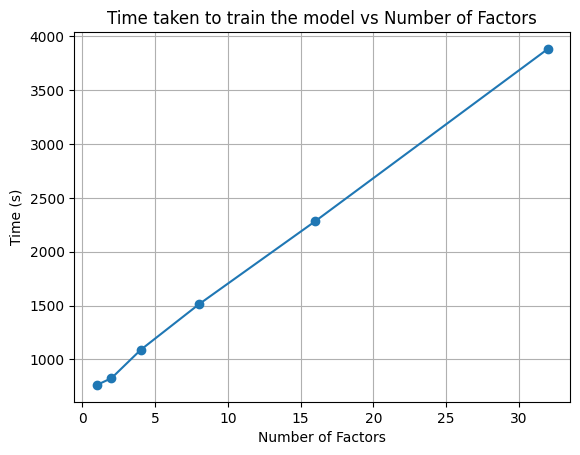

In [10]:
# Plot time taken to train the model vs number of factors
plt.plot(num_factors, train_timer, marker='o')
plt.xlabel('Number of Factors')
plt.ylabel('Time (s)')
plt.title('Time taken to train the model vs Number of Factors')
plt.grid()
plt.show()

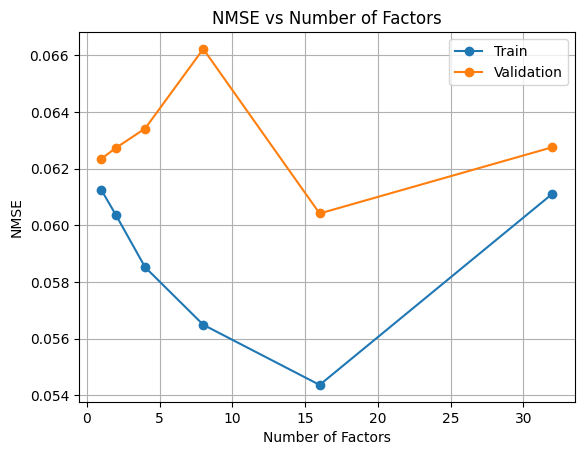

In [11]:
# Plot NMSE of the last epoch vs number of factors
plt.plot(num_factors, nmse_train_results[:, -1], marker='o', label='Train')
plt.plot(num_factors, nmse_val_results[:, -1], marker='o', label='Validation')
plt.xlabel('Number of Factors')
plt.ylabel('NMSE')
plt.title('NMSE vs Number of Factors')
plt.legend()
plt.grid()
plt.show()

### 3. Number of epochs vs NMSE

In [9]:
# Initialize variables
nmse_train_results = np.zeros(NUM_EPOCHS)
nmse_val_results = np.zeros(NUM_EPOCHS)
nmse_test_results = np.zeros(NUM_EPOCHS)

# Create the model
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
nmse_train = NMSE()
nmse_val = NMSE()
nmse_test = NMSE()

# Create the dataset
dataset = create_full_dataset()

# Train the model
for epoch in range(NUM_EPOCHS):
    progress_bar = tqdm(total=NUM_USERS // BATCH_SIZE, desc=f"Epoch {epoch+1}", unit="batch")
    
    for train_batch, val_batch, test_batch in dataset:
        x = model(train_batch)
        nmse_train.update_state(train_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(train_batch, 0.0), tf.float32))
        nmse_val.update_state(val_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(val_batch, 0.0), tf.float32))
        nmse_test.update_state(test_batch, tf.matmul(model.C, x), tf.cast(tf.not_equal(test_batch, 0.0), tf.float32))
        progress_bar.update(1)
    
    progress_bar.close()

    print("Train NMSE:", nmse_train.result().numpy())
    print("Val NMSE:", nmse_val.result().numpy())
    print("Test NMSE:", nmse_test.result().numpy())
    nmse_train_results[epoch] = nmse_train.result().numpy()
    nmse_val_results[epoch] = nmse_val.result().numpy()
    nmse_test_results[epoch] = nmse_test.result().numpy()

Epoch 1: 100%|██████████| 5079/5079 [08:05<00:00, 10.47batch/s]


Train NMSE: 0.052006204
Val NMSE: 0.05826269
Test NMSE: 0.05838645


Epoch 2: 100%|██████████| 5079/5079 [08:02<00:00, 10.54batch/s]


Train NMSE: 0.051792562
Val NMSE: 0.05795282
Test NMSE: 0.058068085


Epoch 3: 100%|██████████| 5079/5079 [08:19<00:00, 10.17batch/s]


Train NMSE: 0.05168372
Val NMSE: 0.05779302
Test NMSE: 0.057907958


Epoch 4: 100%|██████████| 5079/5079 [08:19<00:00, 10.16batch/s]


Train NMSE: 0.05161106
Val NMSE: 0.057686467
Test NMSE: 0.05780144


Epoch 5: 100%|██████████| 5079/5079 [08:14<00:00, 10.27batch/s]


Train NMSE: 0.051557545
Val NMSE: 0.057608344
Test NMSE: 0.05772297


Epoch 6: 100%|██████████| 5079/5079 [08:31<00:00,  9.93batch/s]


Train NMSE: 0.051514916
Val NMSE: 0.05754762
Test NMSE: 0.05766192


Epoch 7: 100%|██████████| 5079/5079 [08:04<00:00, 10.49batch/s]


Train NMSE: 0.051479563
Val NMSE: 0.057497036
Test NMSE: 0.057609312


Epoch 8: 100%|██████████| 5079/5079 [08:01<00:00, 10.55batch/s]


Train NMSE: 0.051450174
Val NMSE: 0.05745362
Test NMSE: 0.05756592


Epoch 9: 100%|██████████| 5079/5079 [07:54<00:00, 10.69batch/s]


Train NMSE: 0.0514243
Val NMSE: 0.057415716
Test NMSE: 0.057528626


Epoch 10: 100%|██████████| 5079/5079 [07:52<00:00, 10.74batch/s]


Train NMSE: 0.051400926
Val NMSE: 0.05738173
Test NMSE: 0.05749357


Epoch 11: 100%|██████████| 5079/5079 [07:52<00:00, 10.76batch/s]


Train NMSE: 0.051380523
Val NMSE: 0.057352357
Test NMSE: 0.05746416


Epoch 12: 100%|██████████| 5079/5079 [07:51<00:00, 10.77batch/s]


Train NMSE: 0.051361836
Val NMSE: 0.057326827
Test NMSE: 0.057437226


Epoch 13: 100%|██████████| 5079/5079 [07:51<00:00, 10.78batch/s]


Train NMSE: 0.051345117
Val NMSE: 0.057302974
Test NMSE: 0.057412393


Epoch 14: 100%|██████████| 5079/5079 [07:49<00:00, 10.81batch/s]


Train NMSE: 0.051329374
Val NMSE: 0.057280663
Test NMSE: 0.05738926


Epoch 15: 100%|██████████| 5079/5079 [07:52<00:00, 10.75batch/s]


Train NMSE: 0.0513149
Val NMSE: 0.057260245
Test NMSE: 0.05736839


Epoch 16: 100%|██████████| 5079/5079 [07:49<00:00, 10.82batch/s]


Train NMSE: 0.051301204
Val NMSE: 0.057241037
Test NMSE: 0.05734915


Epoch 17: 100%|██████████| 5079/5079 [07:50<00:00, 10.79batch/s]


Train NMSE: 0.051288668
Val NMSE: 0.057223465
Test NMSE: 0.057331022


Epoch 18: 100%|██████████| 5079/5079 [07:49<00:00, 10.81batch/s]


Train NMSE: 0.0512769
Val NMSE: 0.05720672
Test NMSE: 0.05731429


Epoch 19: 100%|██████████| 5079/5079 [07:50<00:00, 10.80batch/s]


Train NMSE: 0.051265907
Val NMSE: 0.057190802
Test NMSE: 0.05729861


Epoch 20: 100%|██████████| 5079/5079 [07:49<00:00, 10.82batch/s]

Train NMSE: 0.05125568
Val NMSE: 0.057175927
Test NMSE: 0.057283297


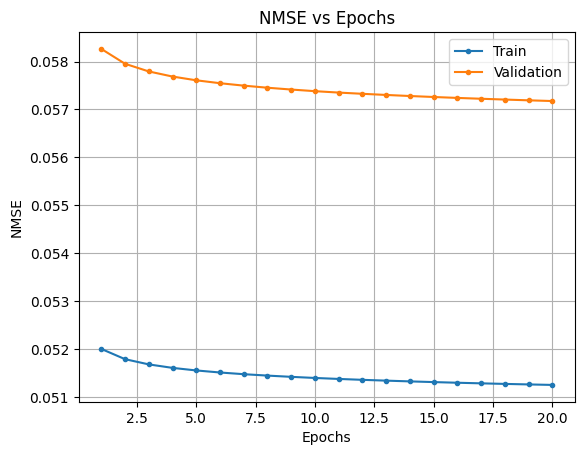

In [10]:
# Plot NMSE vs number of epochs
plt.plot(np.arange(1, NUM_EPOCHS+1), nmse_train_results, marker='.', label='Train')
plt.plot(np.arange(1, NUM_EPOCHS+1), nmse_val_results, marker='.', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('NMSE')
plt.title('NMSE vs Epochs')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Save results to a CSV file
results = pd.DataFrame({
    'Train Results': nmse_train_results,
    'Validation Results': nmse_val_results,
    'Test Results': nmse_test_results
})
results.to_csv('Results/ML25M/num_epochs.csv', index=False)

In [12]:
# Save model weights
model_path = "Results/ML25M/model_weights"
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.write(model_path)

'Results/ML25M/model_weights'

In [13]:
# Check variables in the model
tf.train.list_variables(model_path)

[('_CHECKPOINTABLE_OBJECT_GRAPH', []),
 ('model/C/.ATTRIBUTES/VARIABLE_VALUE', [59047, 16]),
 ('model/V/.ATTRIBUTES/VARIABLE_VALUE', [16, 16])]

In [14]:
# Load model weights
model_path = "Results/ML25M/model_weights"
model = DictionaryFilter(NUM_MOVIES, NUM_FACTORS, INIT_SCALE, TRAIN_LAMBDA)
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(model_path)

In [15]:
# Evaluate the model on the first test batch
dataset = create_full_dataset()
train_batch, val_batch, test_batch = next(iter(dataset))
x = model(train_batch)
pred = tf.matmul(model.C, x)

In [16]:
# Print the predictions
for i, j in tf.where(tf.not_equal(test_batch, 0.0)):
    print(f"i: {i.numpy()}, j: {j.numpy()}, True: {test_batch[i, j].numpy()}, Pred: {pred[i, j].numpy()}")

i: 0, j: 1, True: 3.5, Pred: 4.186559677124023
i: 1, j: 8, True: 5.0, Pred: 4.502417087554932
i: 2, j: 22, True: 5.0, Pred: 3.459651470184326
i: 5, j: 22, True: 4.0, Pred: 4.245947360992432
i: 6, j: 7, True: 1.0, Pred: 3.6868903636932373
i: 9, j: 6, True: 3.0, Pred: 2.772533416748047
i: 15, j: 24, True: 3.0, Pred: 3.9837825298309326
i: 16, j: 6, True: 4.0, Pred: 4.518820285797119
i: 20, j: 24, True: 3.0, Pred: 3.435581922531128
i: 21, j: 11, True: 3.0, Pred: 3.3841960430145264
i: 24, j: 22, True: 4.0, Pred: 4.381397247314453
i: 26, j: 11, True: 2.0, Pred: 2.836233377456665
i: 30, j: 23, True: 4.0, Pred: 3.9863500595092773
i: 31, j: 25, True: 4.5, Pred: 3.5070531368255615
i: 33, j: 31, True: 3.0, Pred: 4.006397247314453
i: 38, j: 31, True: 3.0, Pred: 3.8079299926757812
i: 43, j: 19, True: 3.0, Pred: 3.057725191116333
i: 49, j: 11, True: 5.0, Pred: 4.670222282409668
i: 53, j: 11, True: 2.0, Pred: 3.704169988632202
i: 60, j: 8, True: 4.0, Pred: 4.263418674468994
i: 68, j: 28, True: 3.0, P